# Example of how charge likes to sit at sharp points on a single charged conductive object

Demonstration on surface charge redistribution on complex shaped conductive object, showing that charge likes to sit at places with small radius of curvature. In the course note we derive that the charge will distribute inversely proportional to the radius of curvature. But then a student asked what would happen with negative curvatures and I needed this simulation to help.
(C) Jo Verbeeck, EMAT, University of Antwerp, sept 2019

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal

Create a 2D grid to keep it simple (3D takes longer to calculate and is harder to visualise, but the concept is the same)

In [4]:
#define grid
xmax=1 #extents of grid [m]
xpoints=256 #number of grid points to calculate
x=np.linspace(-xmax,xmax,xpoints)
y=np.linspace(-xmax,xmax,xpoints)
x2d,y2d=np.meshgrid(x,y)
#and also make polar coordinates to easily define a funny shaped object
r=np.sqrt(np.square(x2d)+np.square(y2d))
theta=np.arctan2(x2d,y2d)

Define shape of the conductive object, we use logic function to define where on the grid the object is present (1) or not present (0)

In [21]:
m=6 #symmetry in azimutal direction
r1=xmax/3 #overall radius
a1=r1/5 #amplitude of modulation on the surface

electrode1=r<(r1+a1*np.sin(m*theta))
#and punch a hole in it
holeposx=r1/2
holeposy=0
rhole=r/3
hole=np.sqrt((x2d-holeposx)**2+(y2d-holeposy)**2)>rhole #function that is 0 inside the hole and 1 outside
electrode1=electrode1*hole #make a bitwise AND between the two shapes

#define the potential on the electrode
v1=10

vac=electrode1<1 #logic function defining the vacuum region where no electrodes are present

v=v1*electrode1 #potential boundary conditions=known constant potential on the electrodes

idelectrode=np.where(vac==0) #index for all points that contain electrodes
idvac=np.where(vac==1) #index for all points in vacuum


Show the electrode setup and their potential

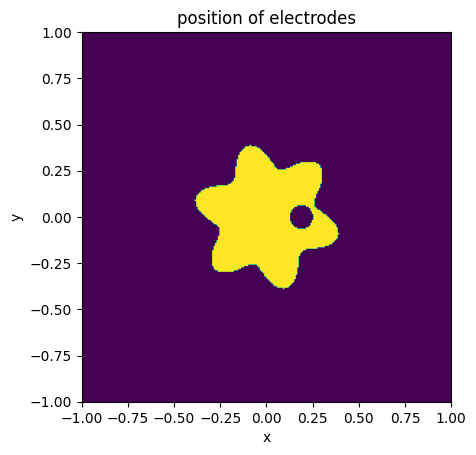

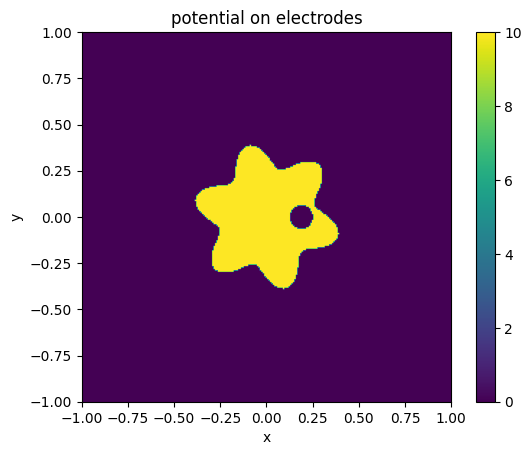

In [22]:

plt.imshow(electrode1,extent=[-xmax,xmax,-xmax,xmax])
plt.axis('square')
plt.title('position of electrodes')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.imshow(v,extent=[-xmax,xmax,-xmax,xmax])
plt.axis('square')
plt.title('potential on electrodes')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

Now solve the Laplace equation for vacuum with boundary conditions 
first rough attempt: all vacuum points to average potential on electrodes (this is clearly too crude but we need to start somewhere)

In [23]:
v[idvac]=np.mean(v[idelectrode]) #replace vacuum potential by the mean potential on the electrodes

Now apply a relaxation method to itteratively find the solution to the laplace equation.
We take each step and smooth the solution with a smoothing kernel (technically we convolve the potential with the kernel)
The kernel is a crude numerical approximation to the mean value theorem stating that the potential inside a sphere is equal to the average potential on the surface of that sphere if no charges are present inside the sphere. 
Faster algorithms exist that start with a rough grid and refine the grid in the process, also the first guess for potential could be a lot smarter when e.g. taking a weighted average depending on distance


In [24]:
vn=v #starting condition is first rough estimate
kmax=1000 #number of itteration steps

kernel=np.array([[1/4,0,1/4],[0,0,0],[1/4,0,1/4]]) #approximative Laplace kernel replacing the central point by the average of 4 neighbouring points. 
error=np.zeros(kmax)

for k in range(kmax):
    vold=vn
    vn=signal.convolve(vold,kernel,mode="same")  #apply kernel to old estimate
    vn[idelectrode]=v[idelectrode] #and reinforce the boundary conditions (on the electrodes we KNOW the potentials)
    dif=vold-vn #difference between old and new estimate
    error[k]=np.sum(np.square(dif)) #square difference as indicator of convergence
   
    #imagesc(Vn); %see how the potential evolves while calculating (but
    #takes a lot of time that should really go to the calculation and not
    #to plotting
    #pause(0.1); %to force refreshing everytime we come here, otherwise the image is not updated

Text(0.5, 0, 'iteration')

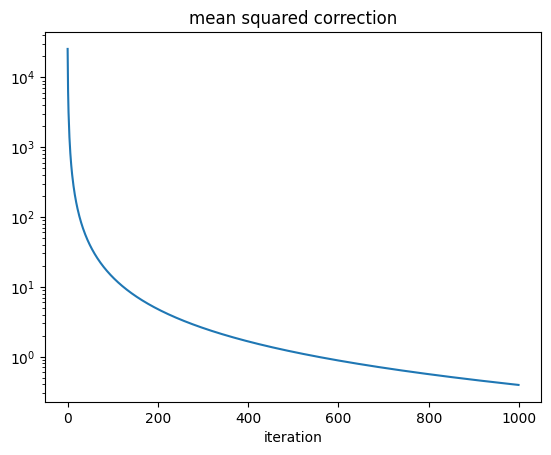

In [25]:
plt.semilogy(error)
plt.title('mean squared correction')
plt.xlabel('iteration')

(-1.0, 1.0, -1.0, 1.0)

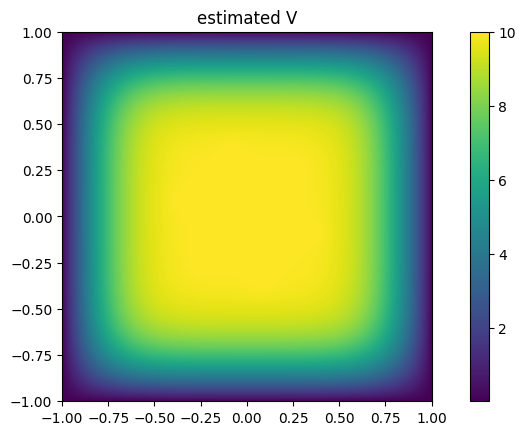

In [26]:
plt.imshow(vn,extent=[-xmax,xmax,-xmax,xmax])
plt.colorbar()
plt.title('estimated V')
plt.axis('square')

Note how the field tends to zero on the edges because of an implicit boundary condition on the edges of the box in our simulation. In reality the square symmetry is unphysical and you would have to take either a much large box or impose a circular boundary condition. In our case we will just ignore the effects for anything that is close to the boundaries of our simulation box.

Now get the fields from E=-grad(V)

In [27]:
ex,ey=np.gradient(-vn,x,y)
e=np.sqrt(np.square(ex)+np.square(ey))

(-1.0, 1.0, -1.0, 1.0)

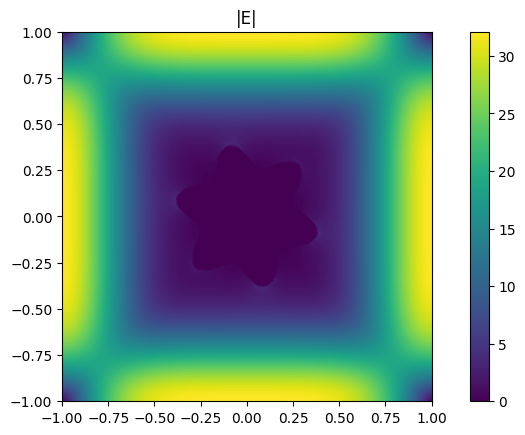

In [28]:
plt.imshow(e,extent=[-xmax,xmax,-xmax,xmax])
plt.colorbar()
plt.title('|E|')
plt.axis('square')

Note how the potential of the inner half-moon electrode does not influence the region outside the shield (hence it is shielding). Try this by varying the potentials of the different electrodes and see what happens.

Now we can calculate the charge density via the divergence of E (alternatively we could calculate the Laplacian of V)

(-1.0, 1.0, -1.0, 1.0)

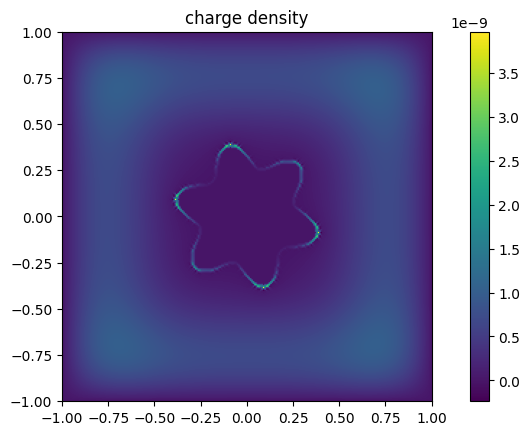

In [29]:
eps0=8.854e-12
dexdx,dexdy=np.gradient(ex,x,y)
deydx,deydy=np.gradient(ey,x,y)
div=dexdx+deydy #apparantly there is no divergence operator in numpy...so we write one ourselves
rho=eps0*div
plt.imshow(rho,extent=[-xmax,xmax,-xmax,xmax])
plt.colorbar()
plt.title('charge density')
plt.axis('square')

Note how charge only appears on the surface of the conductors (as it should). Note how charge likes to sit on the 'pointy' parts of the object whereas almost no charge sit in the indentations. Even though these places have negative curvature, the charge density doesn't become negative but rather tends to zero. When an indentation becomes a completely closed pocket inside the object, and if there is no charge inside this pocket, the surface charge will be exactly zero as the field inside the pocket is also zero. You could view this as an example of shielding as the outer surface configuration of the charge density in the object does not affect the charge distribution on the surface of inner pockets. To bring charge there, you need to insert charge in the space of the pocket which will then in turn not influence any of the charge distribution on the outside surface of the object as these effect get shielded by the object.